# Application demo: optical flow and natural image patches

This notebook demonstrates applications of `circle_bundles` to synthetic optical flow data
and natural image patches.

**Review note**
This notebook is provided as an application-oriented demonstration.
It is not required for software review; see `01_hopf_and_so3.ipynb`
for a minimal tutorial of the core pipeline.


# Imports

In [2]:
# ============================================================
# Core scientific stack
# ============================================================
import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# circle_bundles core API
# ============================================================
from circle_bundles.metrics import RP1AngleMetric as rp1_metric
from circle_bundles.base_covers import MetricBallCover
from circle_bundles.api import build_bundle
from circle_bundles.analysis.local_analysis import get_local_rips, plot_local_rips


# ============================================================
# Persistent homology
# ============================================================
from ripser import ripser
from persim import plot_diagrams


# ============================================================
# Local circular coordinates (optional)
# ============================================================
from dreimac import CircularCoords


# ============================================================
# Synthetic datasets
# ============================================================
from circle_bundles.synthetic.nat_img_patches import (
    sample_nat_img_kb,
    get_gradient_dirs,
)

from circle_bundles.synthetic.opt_flow_patches import sample_opt_flow_torus
from circle_bundles.optical_flow.contrast import get_predominant_dirs


# ============================================================
# Visualization utilities
# ============================================================
from circle_bundles.viz.thumb_grids import show_data_vis
from circle_bundles.viz.lattice_vis import lattice_vis
from circle_bundles.optical_flow.patch_viz import make_patch_visualizer

from circle_bundles.bundle import attach_bundle_viz_methods
attach_bundle_viz_methods()


$\textbf{Problem Setup}$: We consider two synthetic datasets sampled from known models for spaces of high-contrast $n\times n$ image patches and optical flow patches. The optical flow patch model has the topology of a torus embedded in $\mathbb{R}^{2n^{2}}$, while the natural image patch model has the topology of a Klein bottle embedded in $\mathbb{R}^{n^{2}}$. 

For each dataset, we choose a feature map to $\mathbb{RP}^{1}\cong\mathbb{S}^{1}$ to use for analysis. Our goal is to model each dataset as a circle bundle (i.e., fiber bundle with fiber $\mathbb{S}^{1}$) over $\mathbb{RP}^{1}$ and recover the global structure using local-to-global inference techniques. In each case, compute an orientation class representative, then construct a global coordinate system when possible. 

# Torus Model For High-Contrast Optical Flow Patches

Generate a sampling from the model

In [3]:
n_flow_patches = 5000
n_flow = 3   #choose a patch size

rng = np.random.default_rng(0)
flow_data = sample_opt_flow_torus(n_flow_patches, dim = n_flow, rng = rng)[0]
print(f'{n_flow_patches} {n_flow}-by-{n_flow} optical flow patches generated.')

patch_vis = make_patch_visualizer()   #Create a function for patch visualization

5000 3-by-3 optical flow patches generated.


For each high-contrast optical flow patch $x$, compute the predominant flow direction $\pi(x)\in\mathbb{RP}^{1}$ as defined in [1]. 

In [4]:
predom_dirs = get_predominant_dirs(flow_data)[0]
print(f'Predominant directions computed.')

Predominant directions computed.


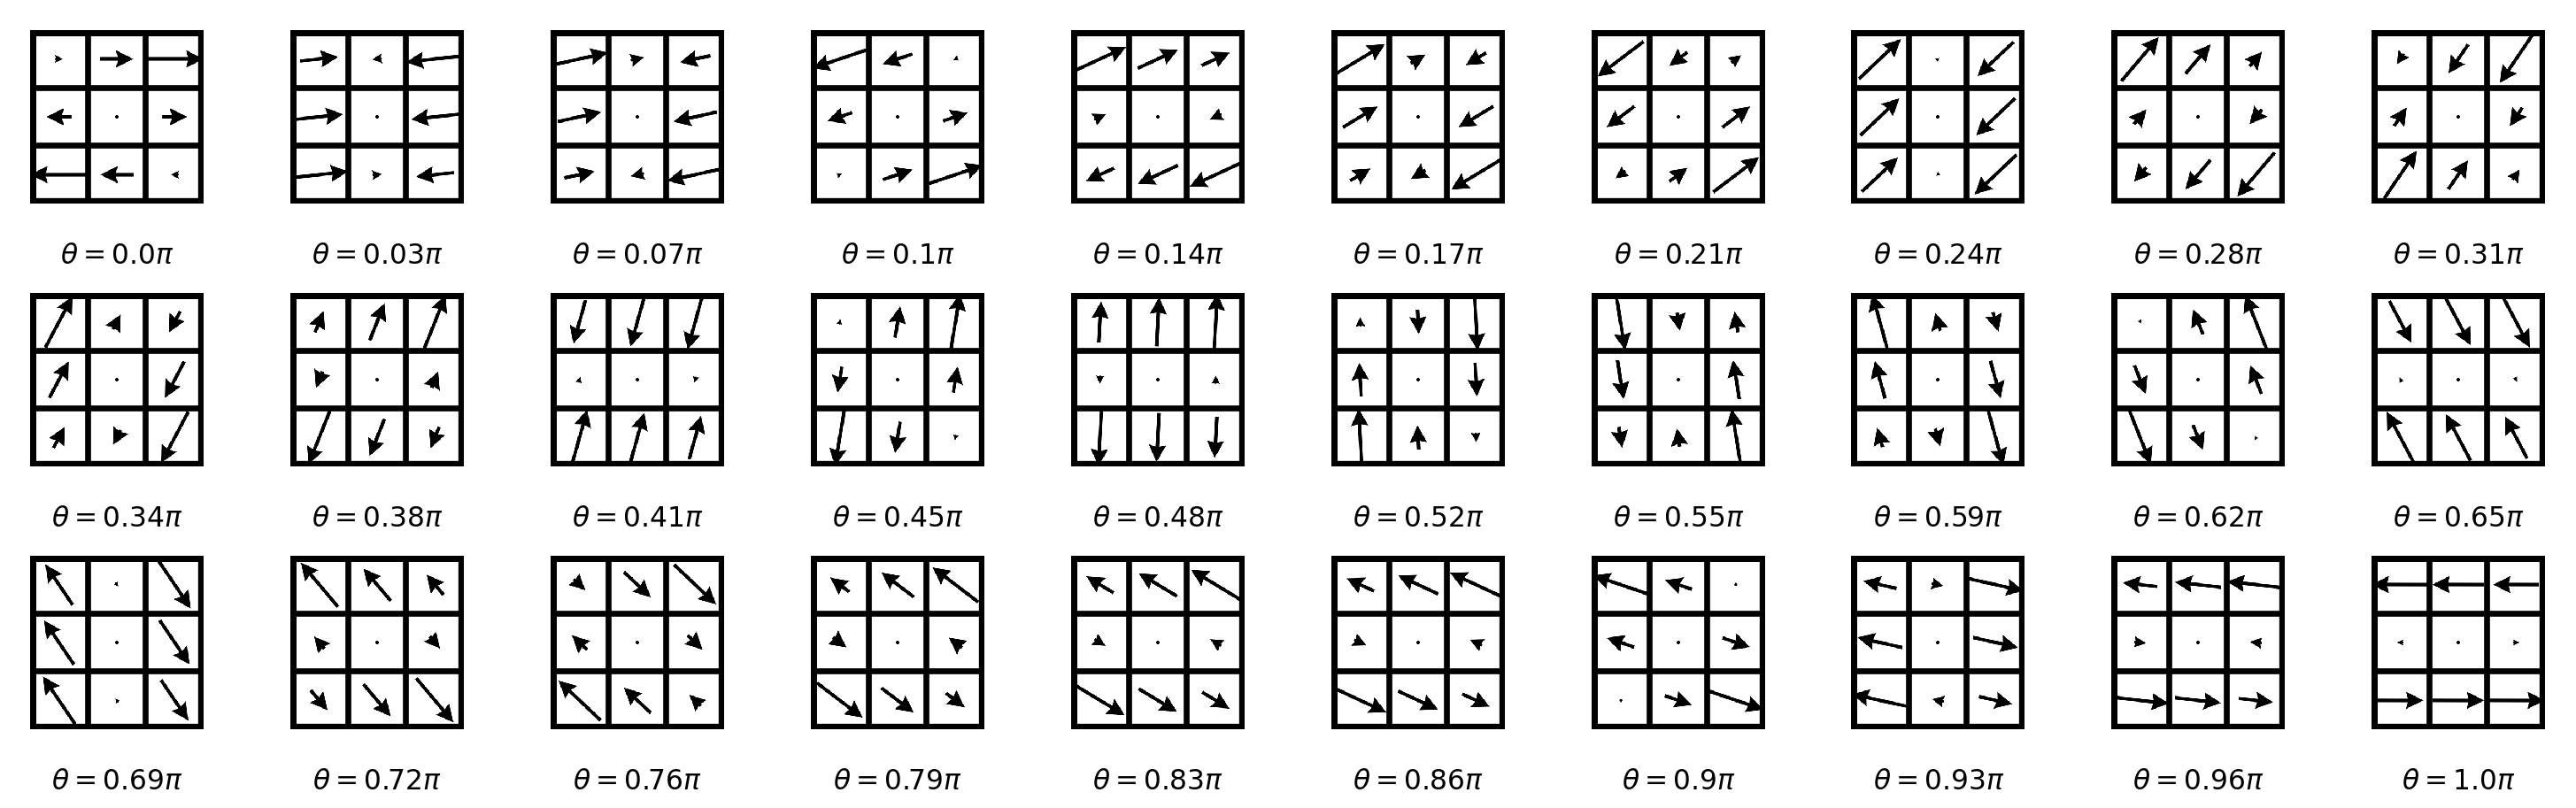

In [5]:
# --- View a random sample of the dataset arranged by predominant flow direction --- 

n_samples = 30

label_func = [fr"$\theta = {np.round(predom_dir/np.pi, 2)}$" + r"$\pi$" for predom_dir in predom_dirs]

fig = show_data_vis(
    flow_data, 
    patch_vis, 
    label_func = label_func, 
    angles = predom_dirs, 
    sampling_method = 'angle', 
    max_samples = n_samples)
plt.show()


Compute persistent homology on a sample of the optical flow dataset as evidence of the global torus structure

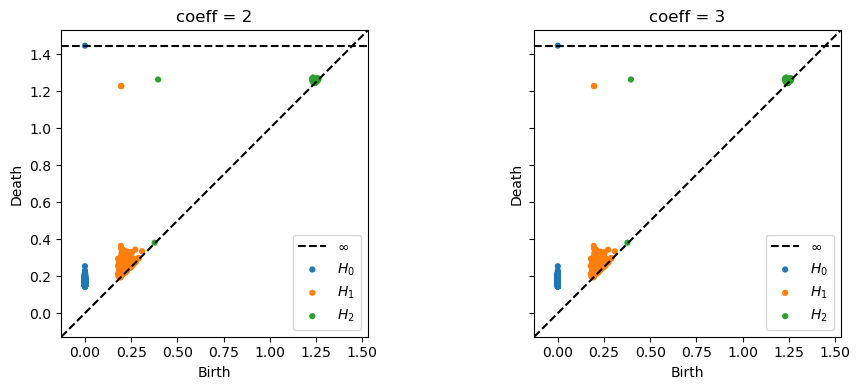

In [6]:
#Compare persistent homology over two different coefficient fields
dgms_2 = ripser(flow_data, coeff=2, maxdim=2, n_perm=500)["dgms"]
dgms_3 = ripser(flow_data, coeff=3, maxdim=2, n_perm=500)["dgms"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title="coeff = 2")
plot_diagrams(dgms_3, ax=axes[1], title="coeff = 3")

plt.tight_layout()
plt.show()


Cover the base space $\mathbb{RP}^{1}$ with a family of metric balls $\{U_{j}\}_{j\in J}$

### Cover And Nerve Summary
- $n_\text{sets} = 12$, $n_\text{samples} = 5000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 12$
- $\#(\text{1-simplices}) = 12$
- *No recorded simplices in dimensions* $\ge 2$

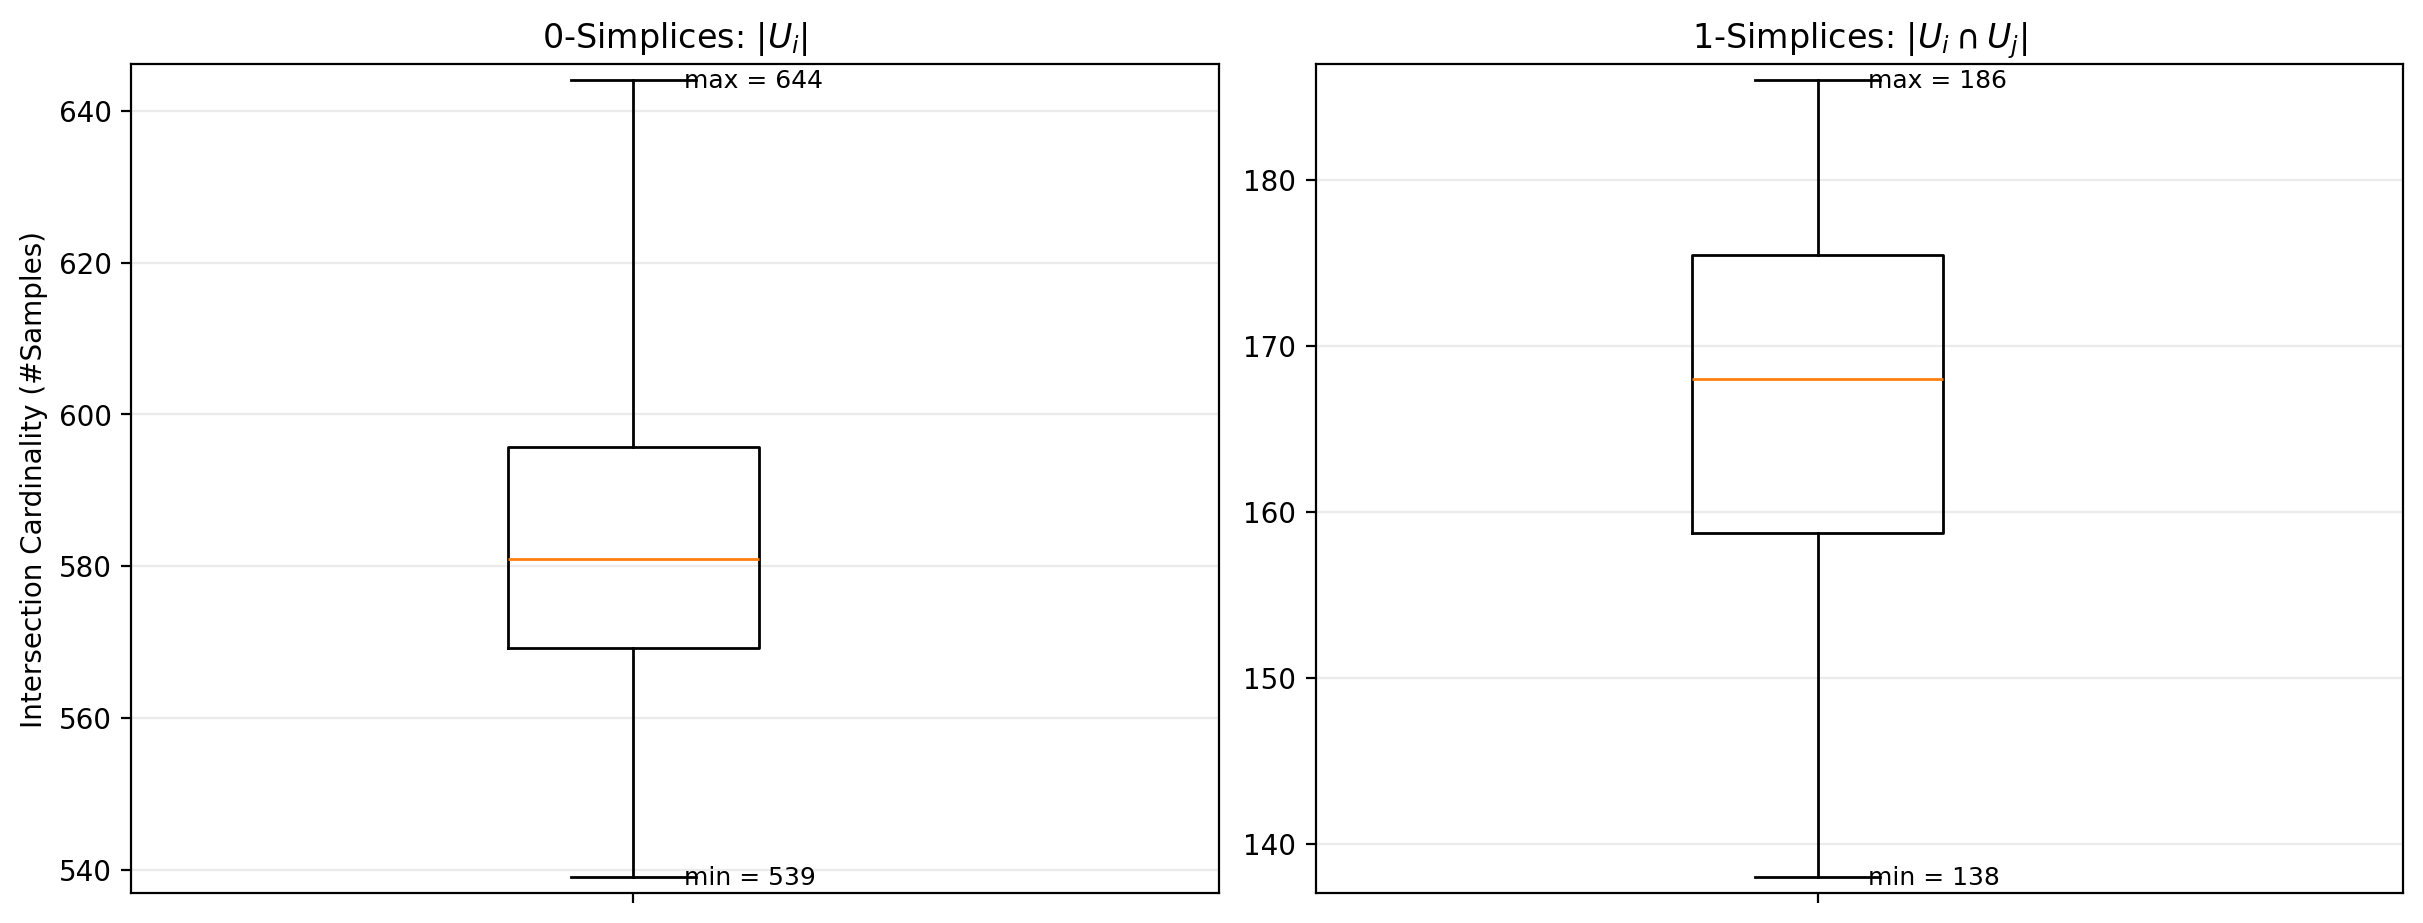

In [7]:
n_flow_landmarks = 12
flow_landmarks = np.linspace(0, np.pi,n_flow_landmarks, endpoint= False)
flow_overlap = 1.4

flow_radius = flow_overlap* np.pi/(2*n_flow_landmarks)

flow_cover = MetricBallCover(predom_dirs, flow_landmarks, flow_radius, metric = rp1_metric())
flow_cover_data = flow_cover.build()

flow_summ = flow_cover.summarize(plot=True)  #Show a summary of the constructed cover
plt.show()

Compute 1D persistence on the data in each set $\pi^{-1}(U_{j})$ to check for local circular features

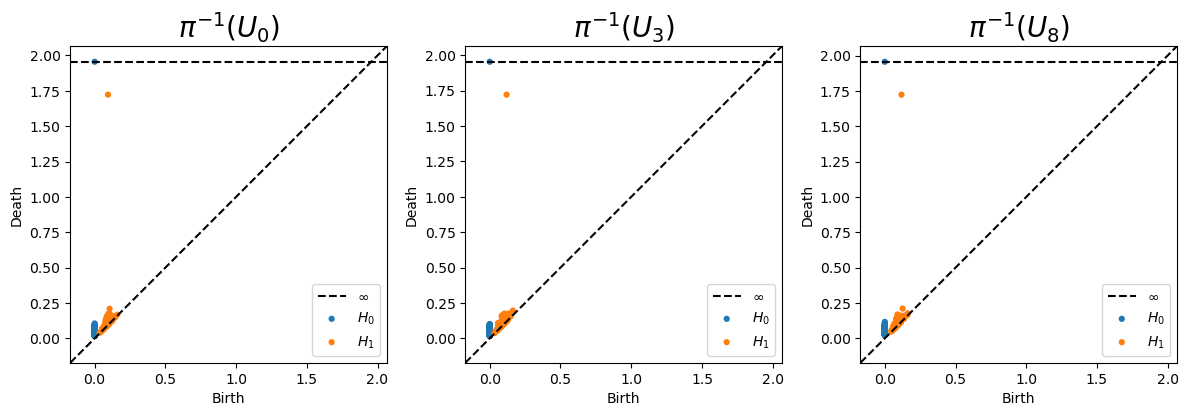

In [8]:
fiber_ids, dense_idx_list, rips_list = get_local_rips(
    flow_data,
    flow_cover.U,
    to_view = [0,3,8],
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles='default',
    font_size=20,
)

$\textbf{Main bundle construction}:$  Compute local circular coordinates (using PCA or the sparse circular coordinates algorithm from the Dreimac library) and construct approximate transition matrices using Procrustes analysis.  

Compute an orientation class representative $\omega\in \check{Z}^{1}(\mathcal{U};\underline{\mathbb{Z}_{2}})$ and check whether it is a coboundary (as expected for a torus).

In [9]:
flow_bundle = build_bundle(
    flow_data,
    flow_cover,
#    CircularCoords_cls=CircularCoords,     #OPTION: use Dreimac for circular coordinates
    show=True,
)


<IPython.core.display.Math object>

Compute a global toroidal coordinate system for the dataset by syncronizing local circular coordinates

In [10]:
flow_triv_result = flow_bundle.get_global_trivialization()
print('Global coordinates computed.')

Global coordinates computed.


Show a sample of optical flow patches arranged according to assigned toroidal coordinates

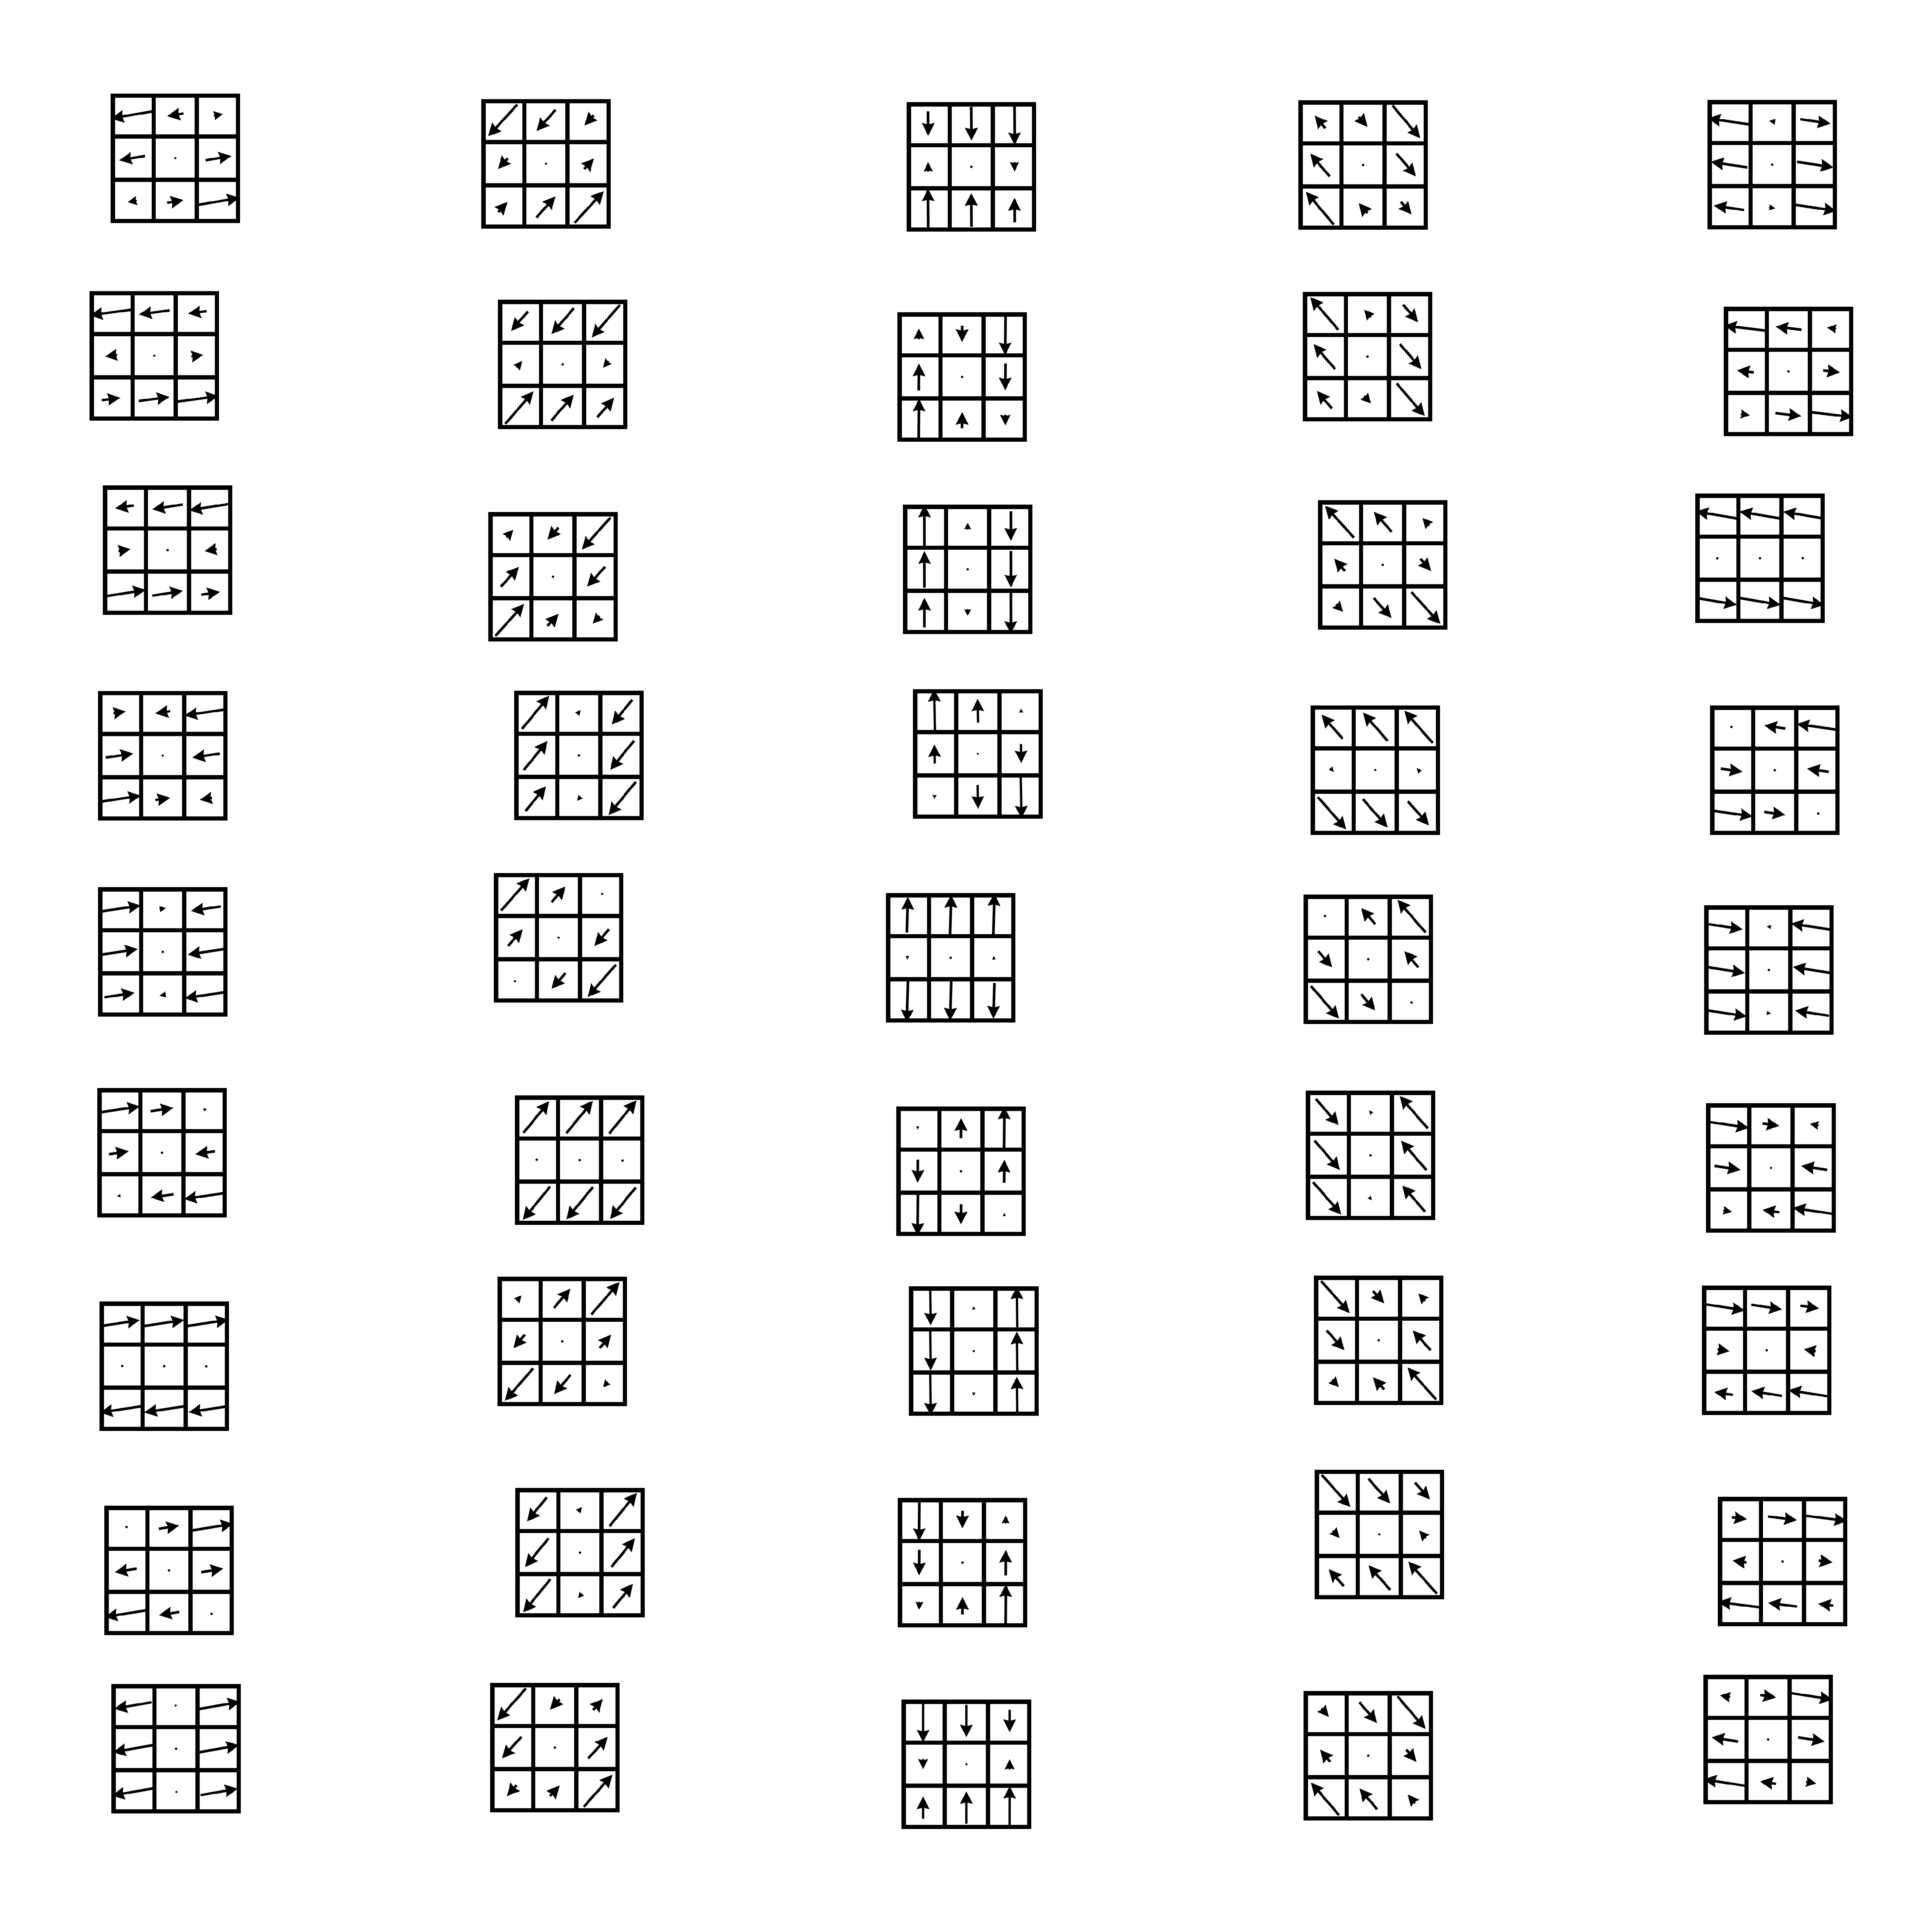

In [11]:
per_row = 5
per_col = 9
coords = np.column_stack([predom_dirs.reshape(-1,1), flow_triv_result.F.reshape(-1,1)])

fig = lattice_vis(
    flow_data,
    coords,
    patch_vis,
    per_row=per_row,
    per_col = per_col,
    figsize=19,
    thumb_px=350,   
    dpi=350         
)

plt.show()


# Klein Bottle Model For High-Contrast Natural Image Patches

We now apply the same analysis to a synthetic dataset of high-contrast natural image patches and compare the results. Here, we analogously use predominant gradient direction as our projection map to $\mathbb{RP}^{1}$.

In [12]:
#Generate the dataset

n_img_patches = 5000  
n_img = 3   #Choose a patch size

rng = np.random.default_rng(0)
img_data = sample_nat_img_kb(n_img_patches, n = n_img, rng = rng)[0]  

print(f'{n_img_patches} {n_img}-by-{n_img} natural image patches generated.')

5000 3-by-3 natural image patches generated.


In [13]:
#Compute predominant gradient directions in RP1

grad_dirs = get_gradient_dirs(img_data)[0]   
print(f'Predominant gradient directions computed.')

Predominant gradient directions computed.


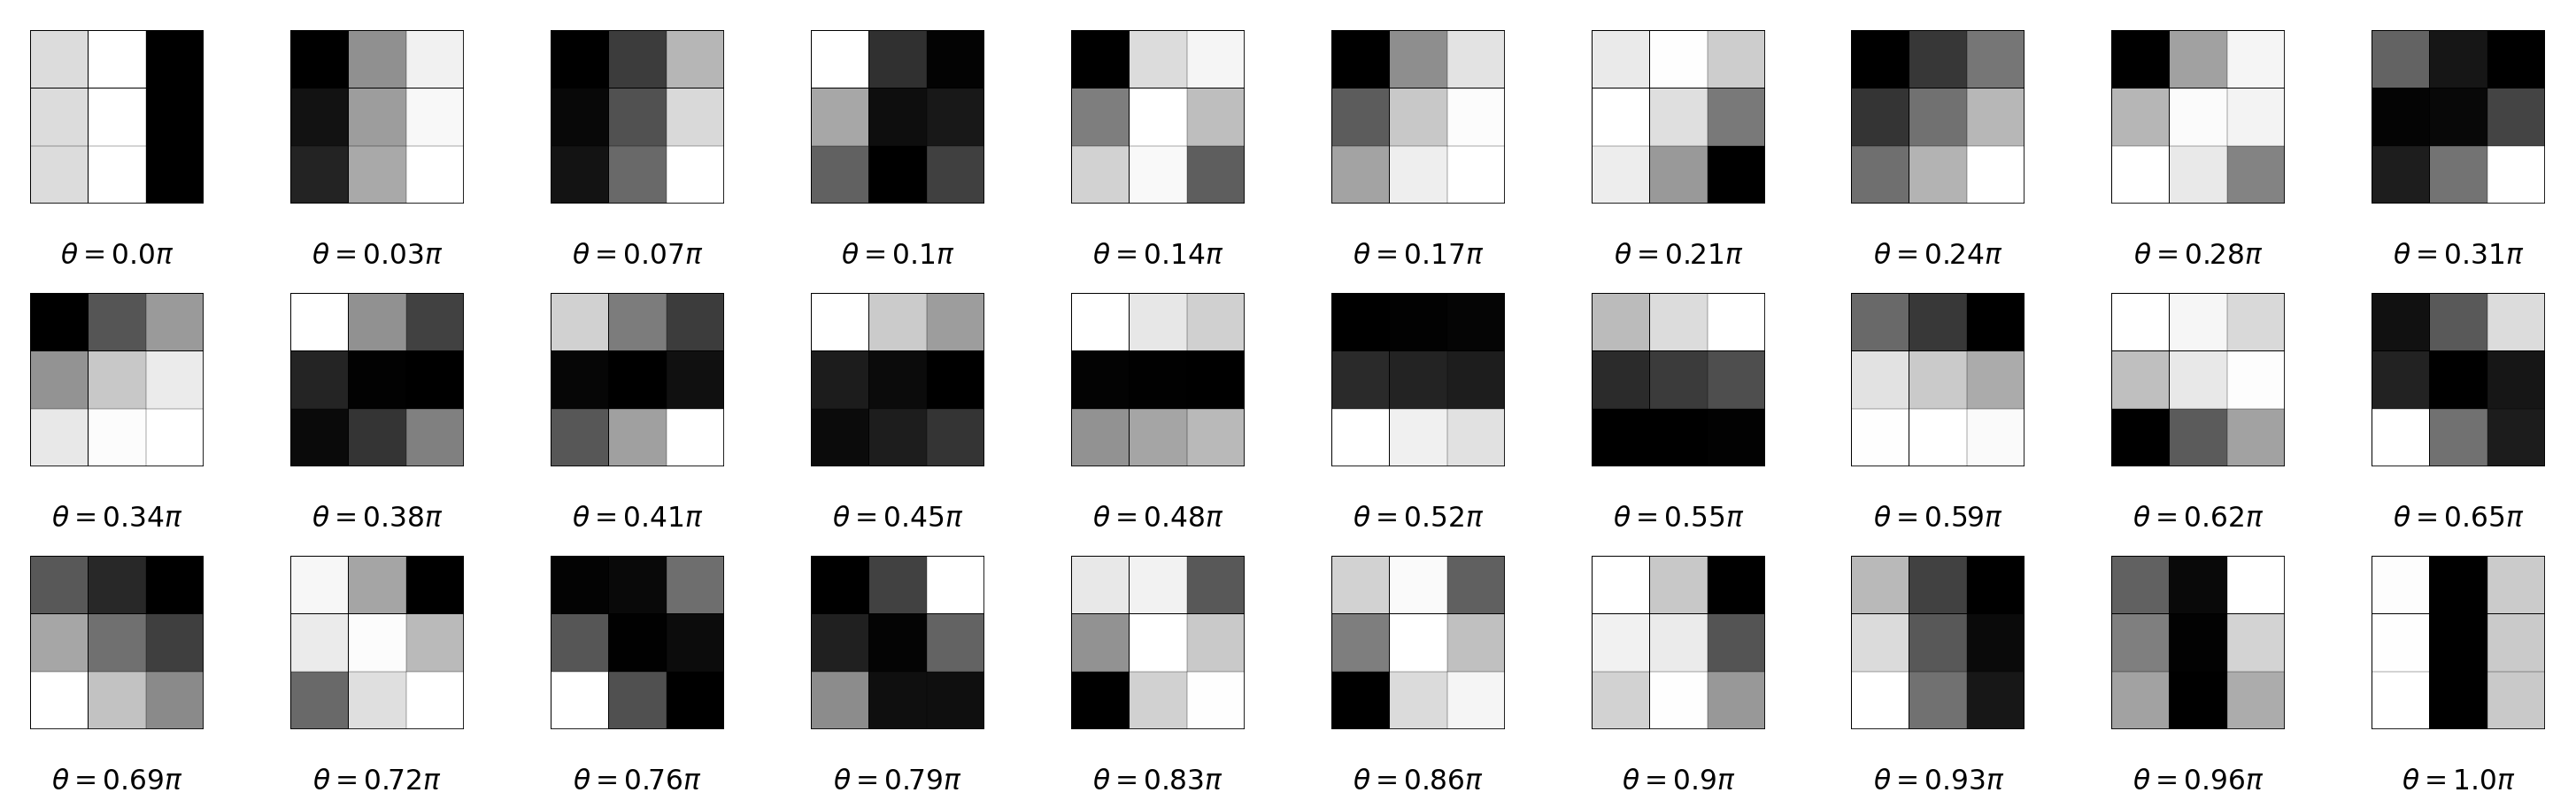

In [14]:
#View a small random sample of the dataset arranged by gradient direction
n_samples = 30

label_func = [fr"$\theta = {np.round(grad/np.pi, 2)}$" + r"$\pi$" for grad in grad_dirs]

fig = show_data_vis(
    img_data, 
    patch_vis, 
    label_func = label_func, 
    angles = grad_dirs, 
    sampling_method = 'angle', 
    max_samples = n_samples)
plt.show()


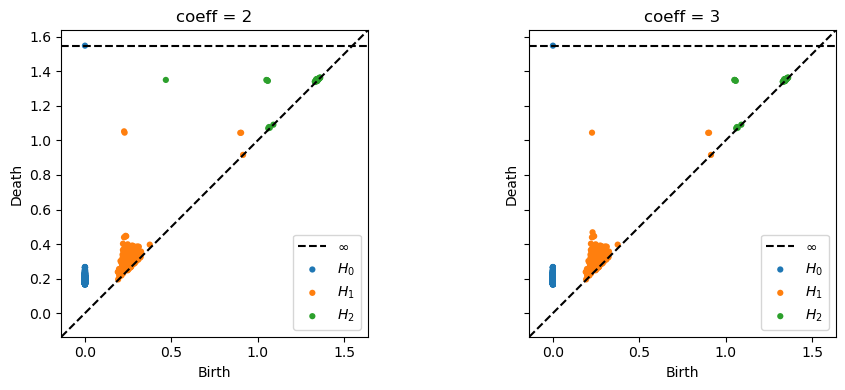

In [15]:
#Run Ripser on a sample of the dataset to confirm the Klein bottle topology

#Compare persistent homology over two different coefficient fields
dgms_2 = ripser(img_data, coeff=2, maxdim=2, n_perm=500)["dgms"]
dgms_3 = ripser(img_data, coeff=3, maxdim=2, n_perm=500)["dgms"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title="coeff = 2")
plot_diagrams(dgms_3, ax=axes[1], title="coeff = 3")

plt.tight_layout()
plt.show()


### Cover And Nerve Summary
- $n_\text{sets} = 12$, $n_\text{samples} = 5000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 12$
- $\#(\text{1-simplices}) = 12$
- *No recorded simplices in dimensions* $\ge 2$

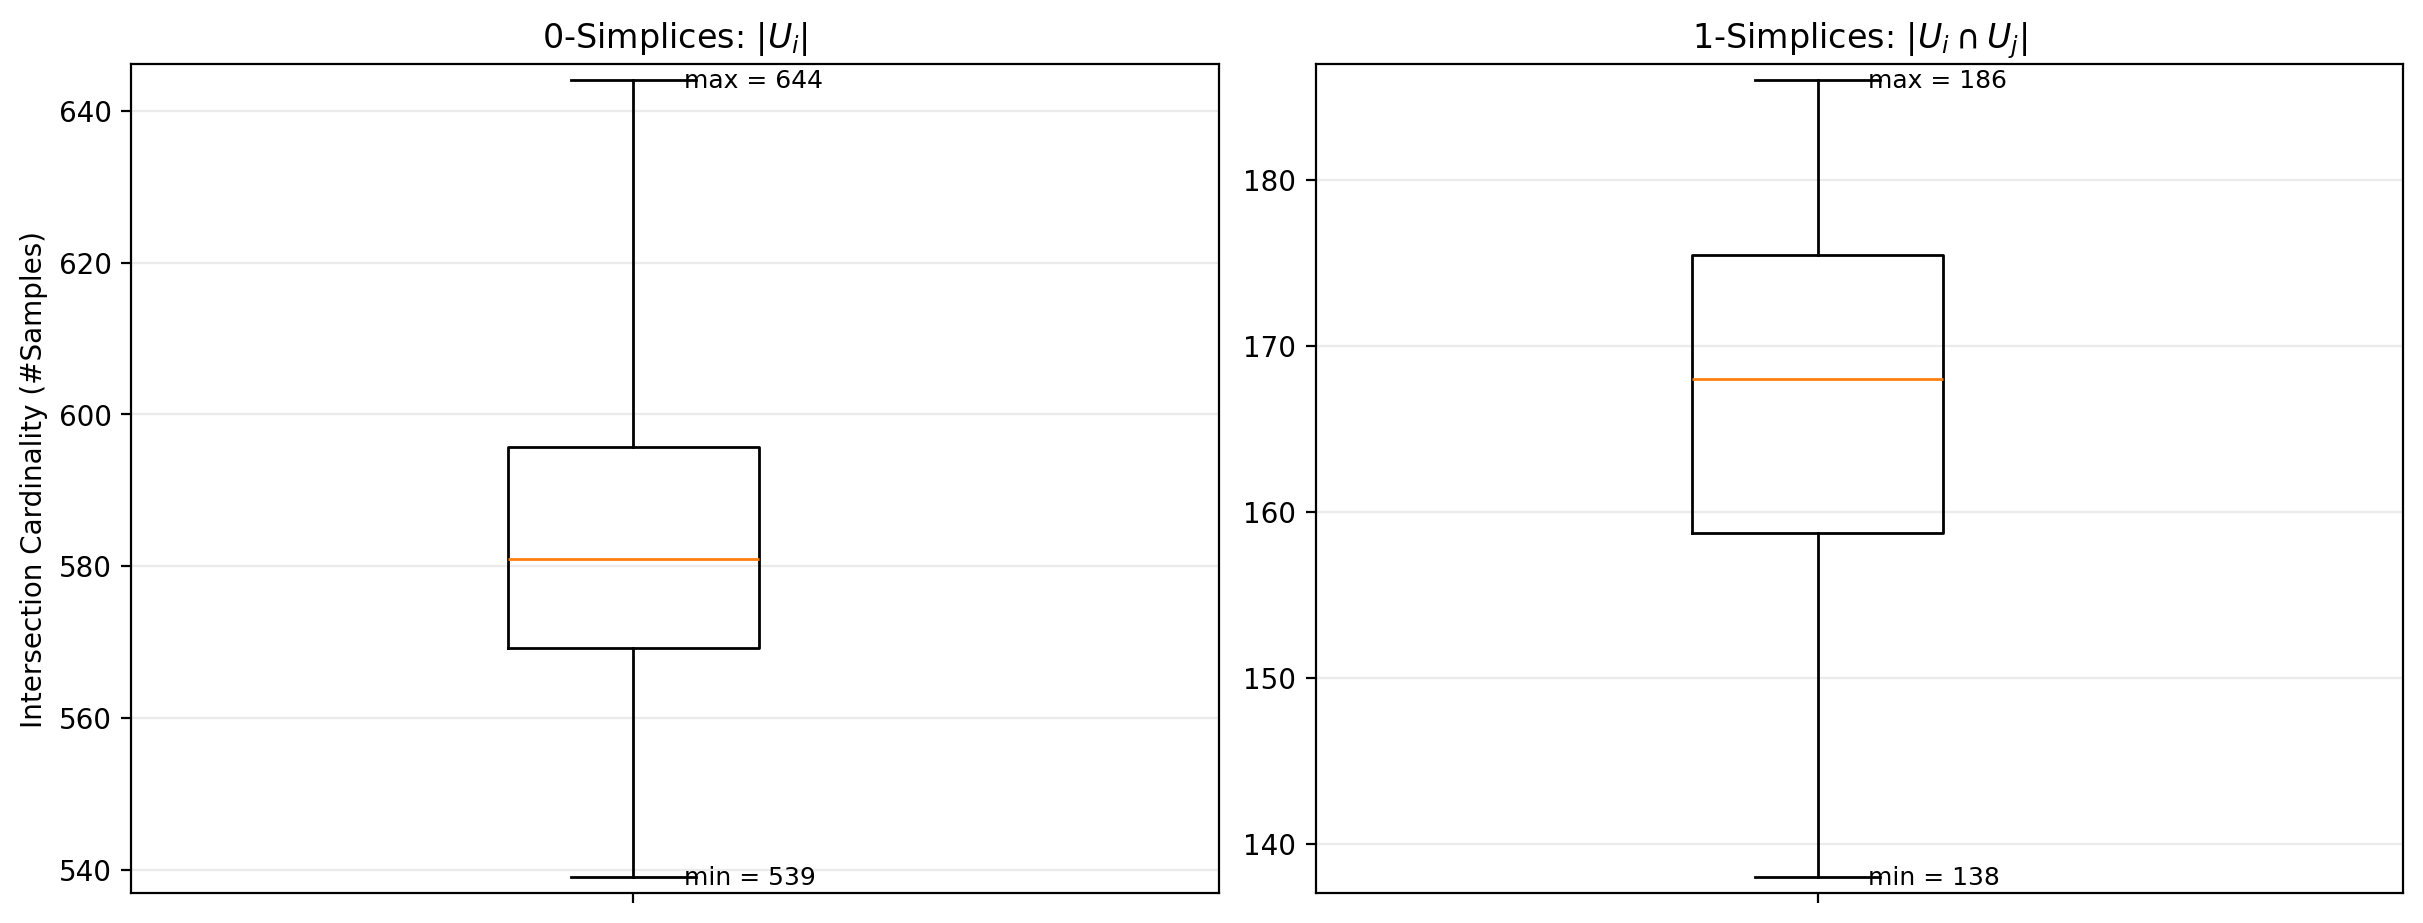

In [16]:
#Construct a cover of the base space RP1

n_img_landmarks = 12
img_landmarks = np.linspace(0, np.pi,n_img_landmarks, endpoint= False)
img_overlap = 1.4

img_radius = img_overlap* np.pi/(2*n_img_landmarks)

img_cover = MetricBallCover(grad_dirs, img_landmarks, img_radius, metric = rp1_metric())
img_cover_data = img_cover.build()

img_summ = img_cover.summarize(plot=True) 
plt.show()

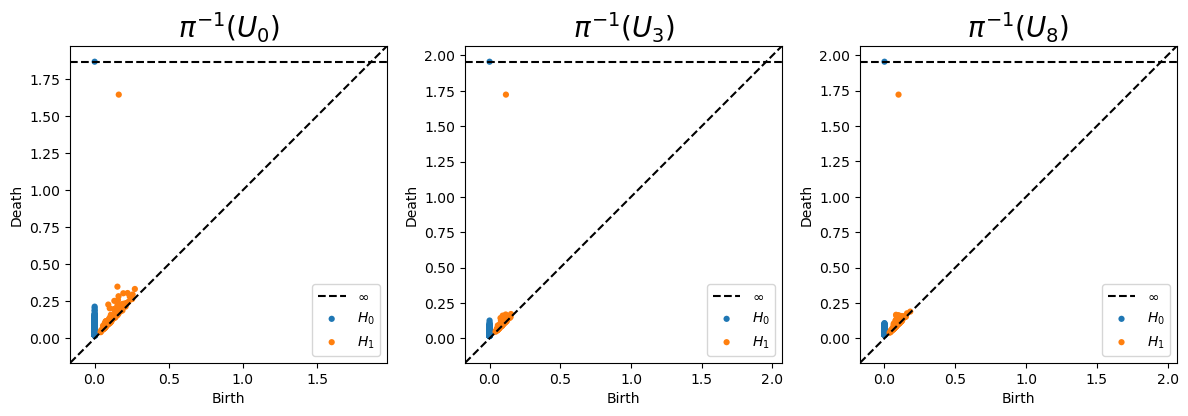

In [17]:
#Run persistence on data over each open set to confirm local circular features

fiber_ids, dense_idx_list, rips_list = get_local_rips(
    img_data,
    img_cover.U,
    p_values=None,
    to_view = [0,3,8],
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles='default',
    font_size=20,
)

In [18]:
#Main bundle construction 

img_bundle = build_bundle(
    img_data,
    img_cover,
#    CircularCoords_cls=CircularCoords,     #OPTION: use Dreimac for circular coordinates
    show=True,
)


<IPython.core.display.Math object>

Our bundle analysis confirms the non-trivial global structure, so a global trivialization is not possible here. Instead, we remove an edge from the nerve of the open cover (corresponding to the set intersection with the poorest Procrustes alignment quality), and compute coordinates which reflect this cut.  

In [19]:
img_triv_result = img_bundle.get_global_trivialization()
print('Global coordinates computed.')

Global coordinates computed.


Notice the abrupt reflection in the coordinates between columns 2 and 3 in the diagram produced below

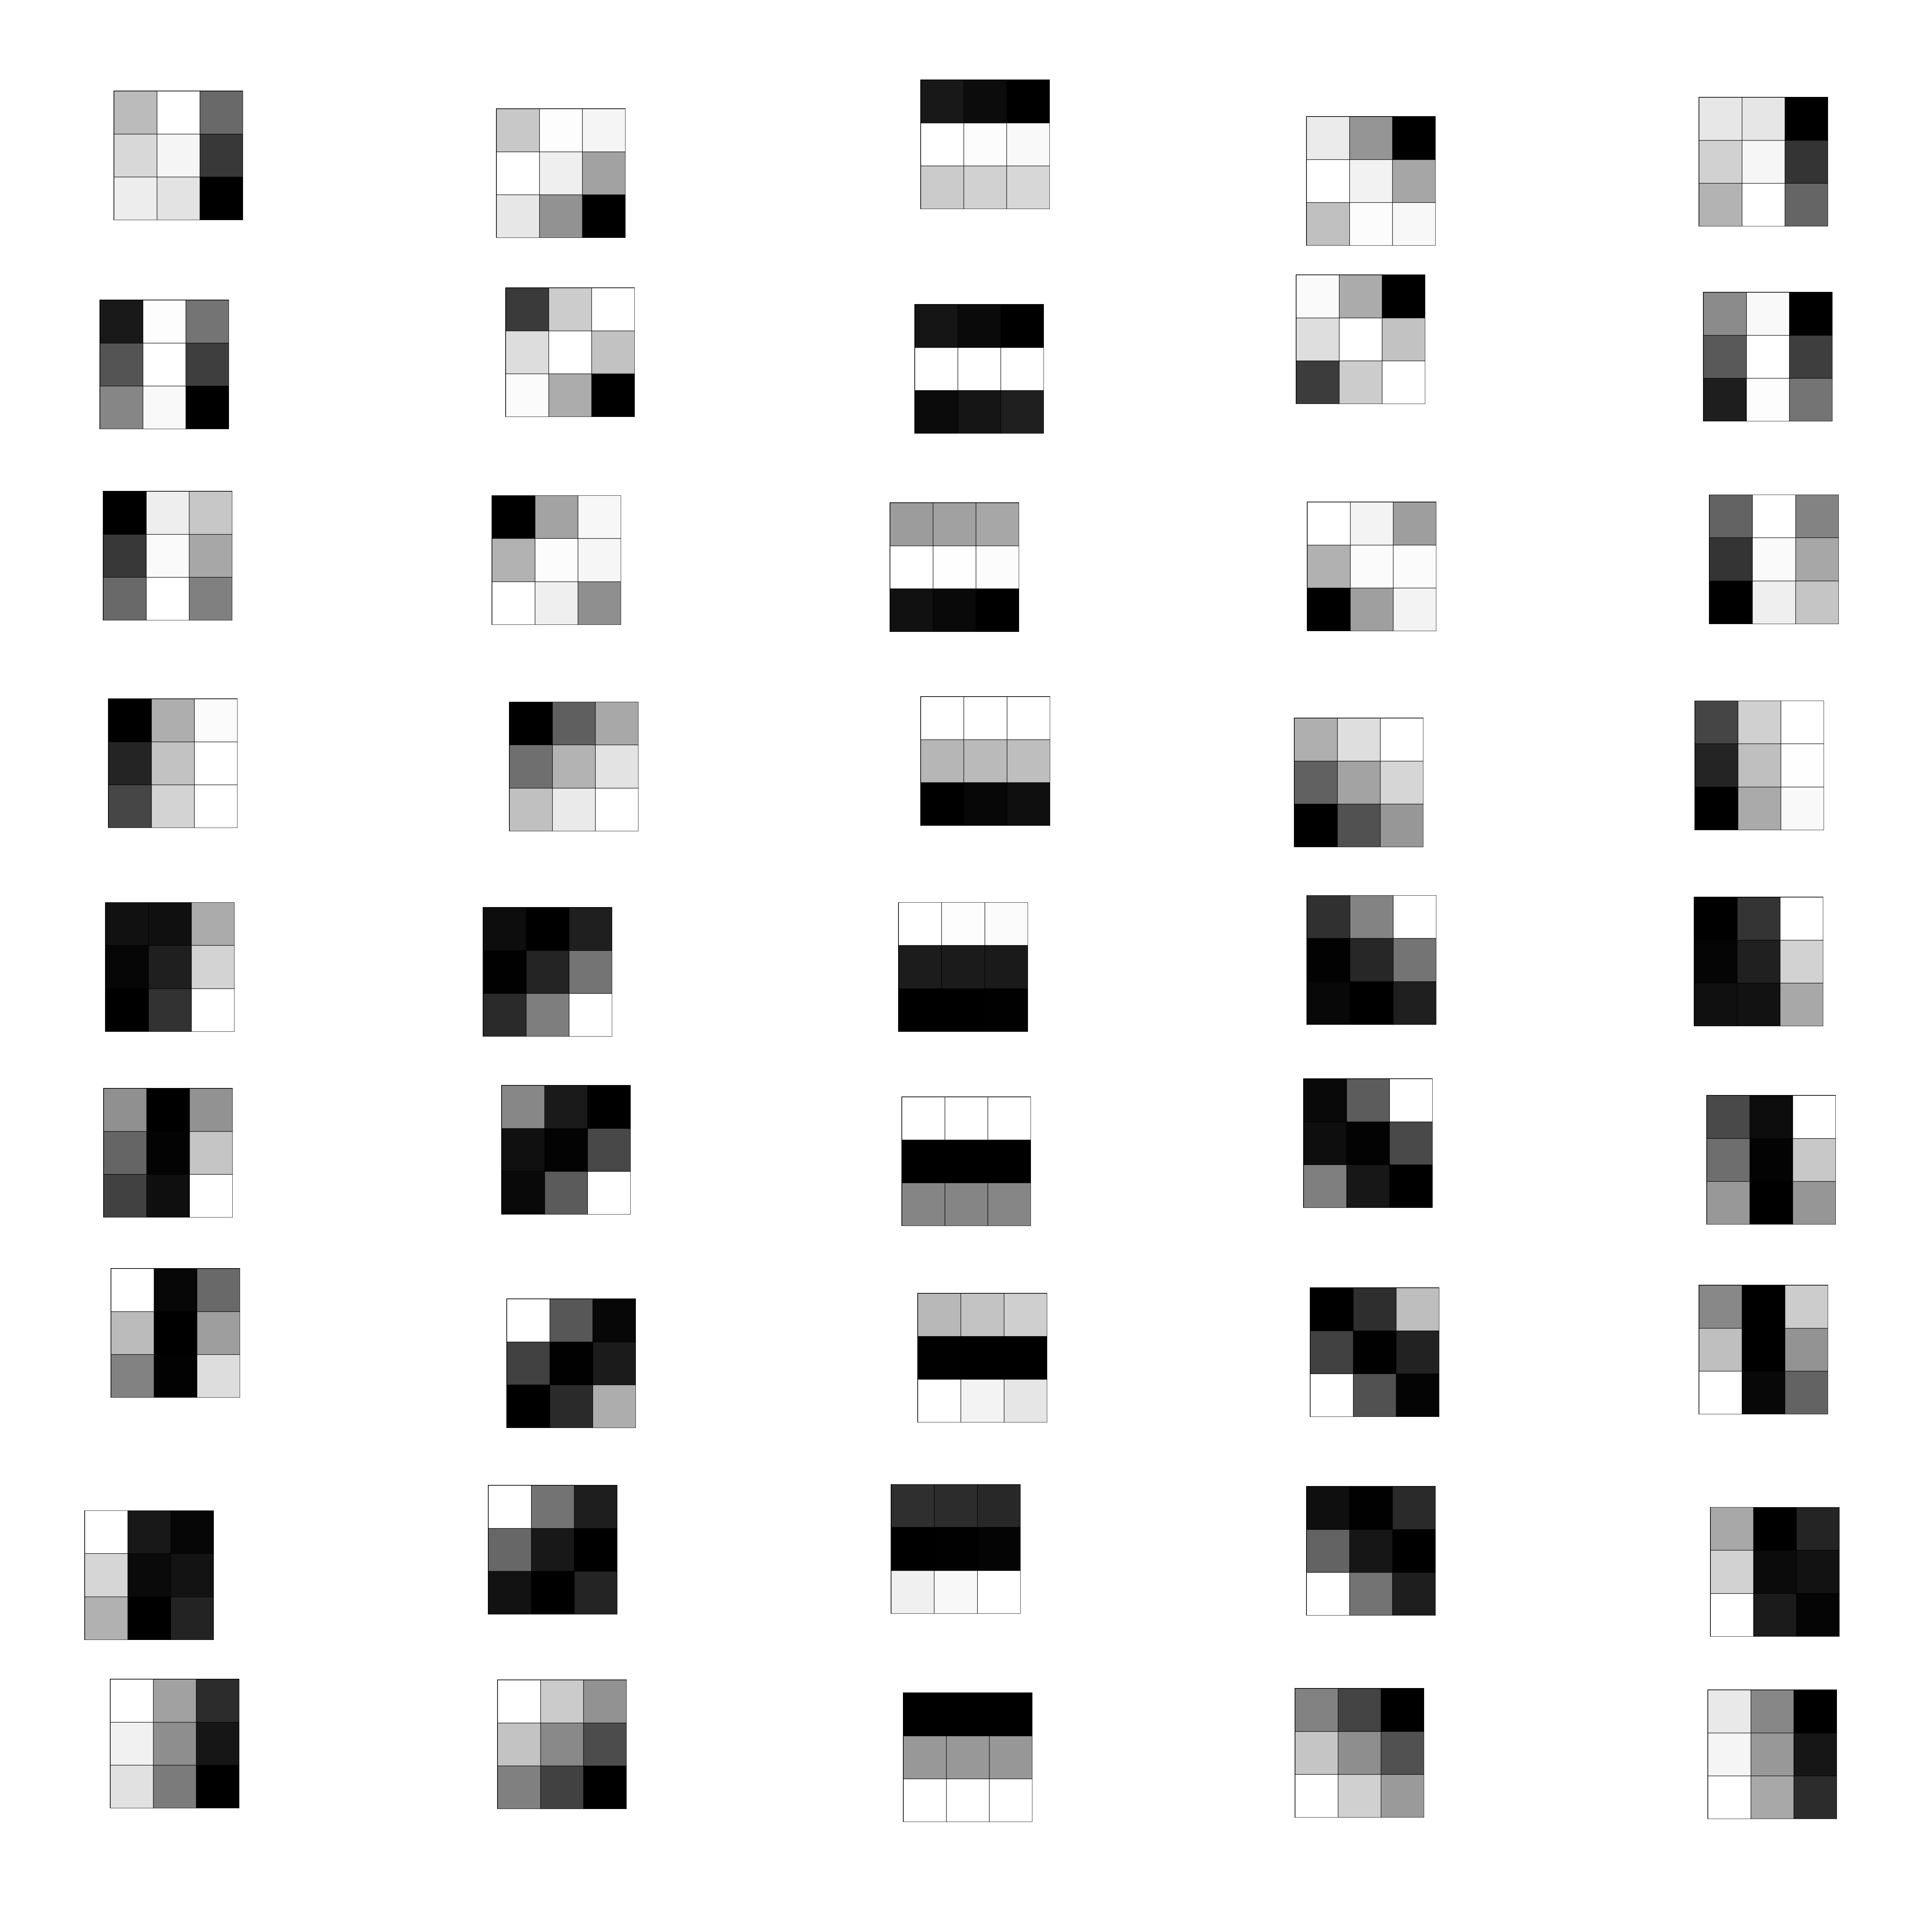

In [20]:
#Show a sample of coordinatized patches
per_row = 5
per_col = 9
coords = np.column_stack([grad_dirs.reshape(-1,1), img_triv_result.F.reshape(-1,1)])

fig = lattice_vis(
    img_data,
    coords,
    patch_vis,
    per_row=per_row,
    per_col = per_col,
    figsize=19,
    thumb_px=350,   
    dpi=350         
)

plt.show()


# Additional Visualization -- Orientation Cocycle Comparisons

We show a visualization of the nerve of the open cover of $\mathbb{RP}^{1}$ used to analyze each dataset, with edges decorated by the values of the computed orientation cocycle representative.  The 'weight' assigned to each edge, measuring the quality of Procrustes alignment on the corresponding set intersection, is shown for the two datasets.  In the case of the natural image patches, the edge which was removed for coordinatization is indicated.  Potentials for the orientation cocycles (after restriction in the Klein bottle case) are shown in red. 

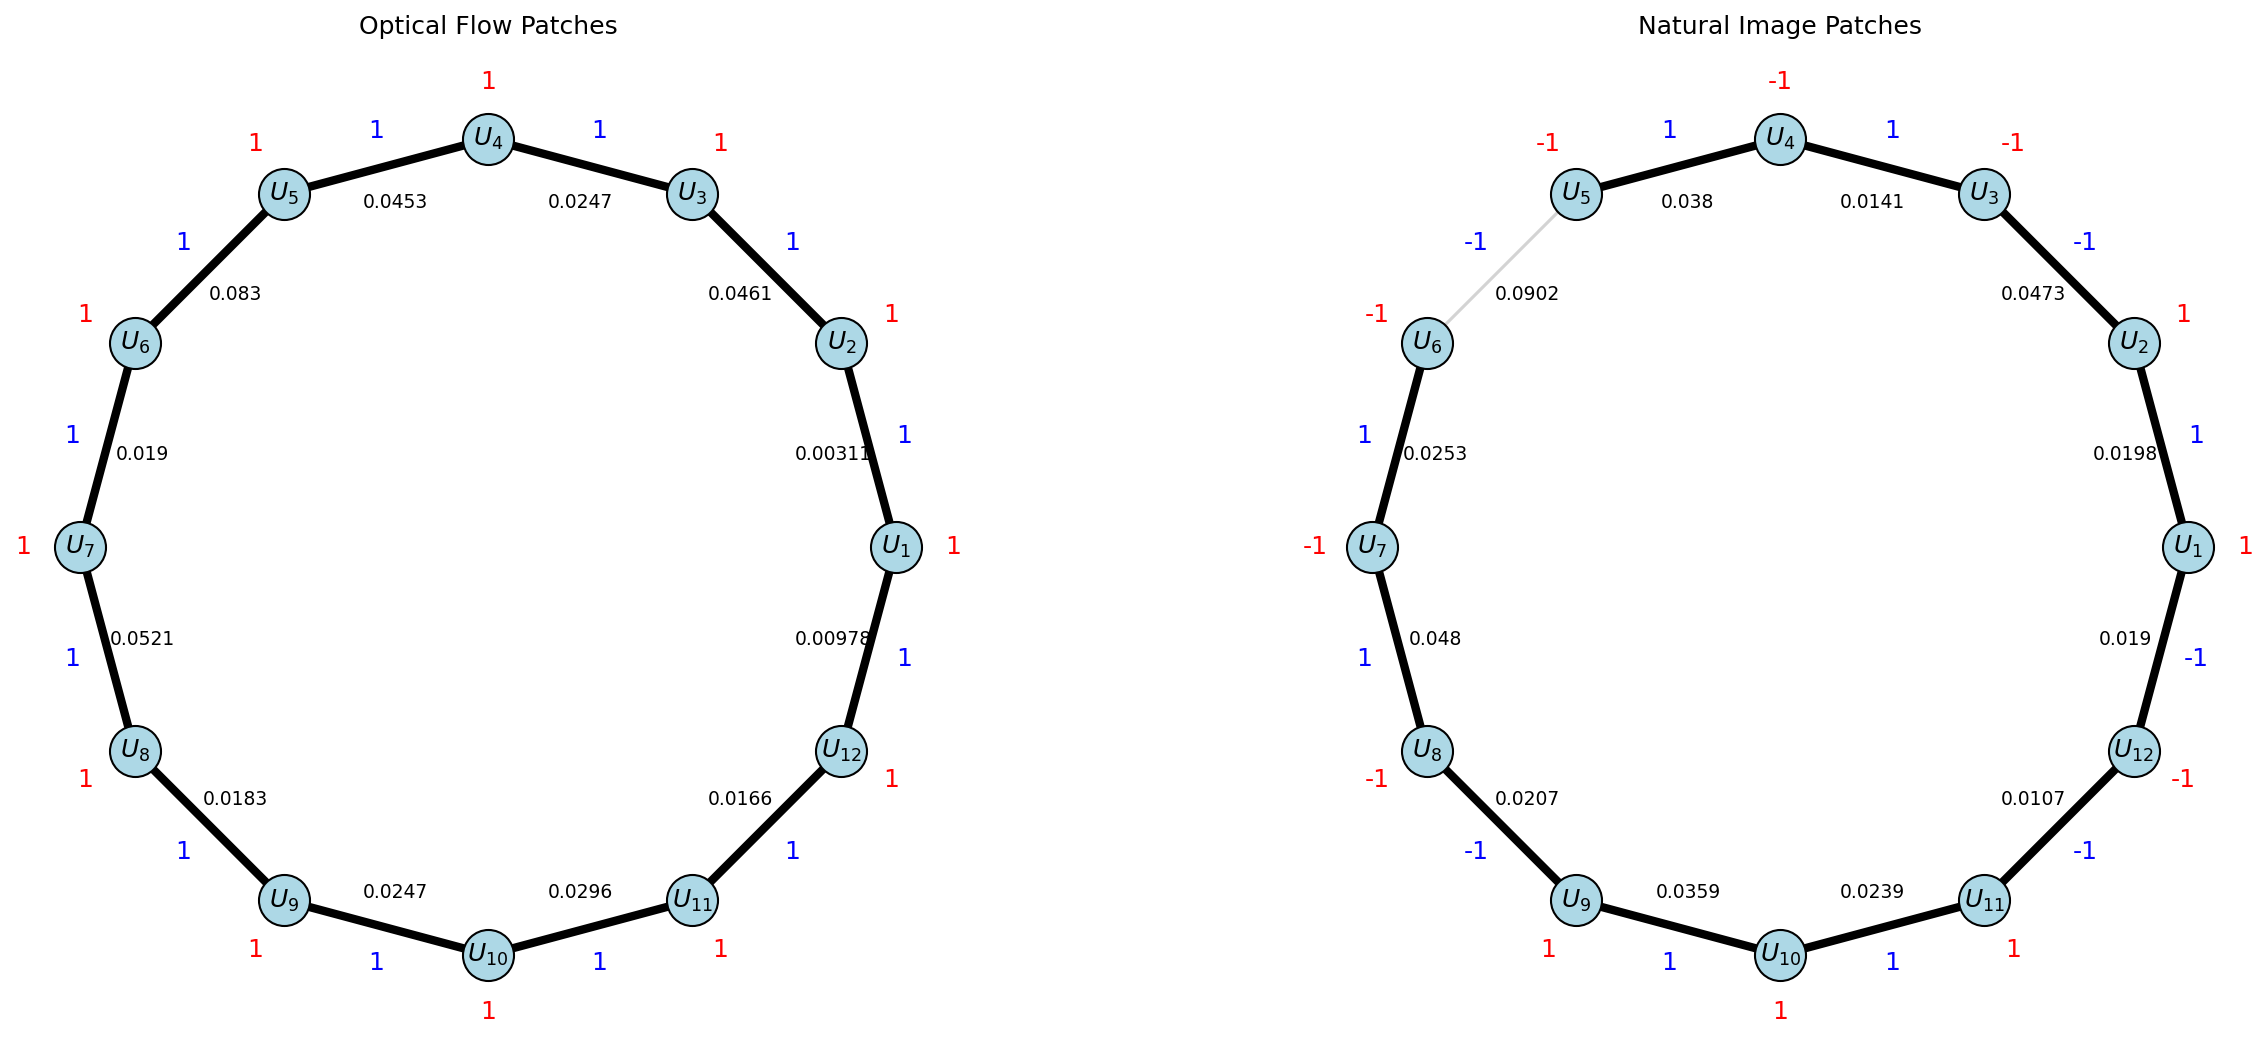

In [21]:
#Compare the orientation class representatives for the two datasets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), dpi=150)


flow_bundle.show_circle_nerve(
    title="Optical Flow Patches",
    ax=ax1,
    show=False,
)

img_bundle.show_circle_nerve(
    title="Natural Image Patches",
    ax=ax2,
    show=False,
)


plt.tight_layout()
plt.show()
